In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [41]:
df = pd.read_excel("../data/brote_dengue.xlsx")
df.columns = ["Temp_Seca_Max","Precipitacion","Temp_Seca_Min","Hum_Rel_Min","Hum_Rel_Max","brote","Dengue"]
df = df[["Temp_Seca_Max","Precipitacion","Temp_Seca_Min","Hum_Rel_Min","Hum_Rel_Max","Dengue"]]
df = df.dropna()
df

,Temp_Seca_Max,Precipitacion,Temp_Seca_Min,Hum_Rel_Min,Hum_Rel_Max,Dengue
0,25.866667,3.700000,19.433333,47.500000,91.666667,2
1,28.200000,0.000000,20.800000,40.833333,91.333333,2
2,29.066667,0.033333,20.933333,45.333333,94.333333,1
3,30.266667,11.133333,20.500000,57.833333,92.000000,1
4,28.133333,1.016667,18.600000,50.833333,89.166667,2
...,...,...,...,...,...,...
93,28.200000,2.783333,20.066667,46.833333,86.500000,22
94,27.066667,7.050000,20.966667,49.500000,87.666667,18
95,28.933333,4.350000,20.933333,44.166667,87.666667,17
96,29.933333,0.733333,20.700000,45.000000,87.500000,14


In [42]:
def poisson_regressor_with(df,slag, seed = 42, shuffle = True):
    X = df[["Temp_Seca_Max","Precipitacion","Temp_Seca_Min","Hum_Rel_Min","Hum_Rel_Max"]].values
    y = df["Dengue"].values

    n_samples,n_features = X.shape

    #Se hace el ventaneo para obtener los datos de entrenamiento
    new_X = []
    for i in range(0,n_samples - slag ):
        X_raveled = X[i:i+slag,:].ravel()
        new_X.append(X_raveled)
    new_X = np.array(new_X)
    new_y = y[slag:]

    # print(f'Utilizando un Slag de {slag} tenemos X: {new_X.shape} y: {new_y.shape}')
    X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, 
                                                        test_size=0.20, 
                                                        random_state=seed,
                                                        shuffle = shuffle)
    ind_train, ind_test = train_test_split(np.arange(new_X.shape[0]),
                                                        test_size=0.20, 
                                                        random_state=seed,
                                                        shuffle = shuffle)
    
    #Estadistico
    # est = sm.OLS(y_train,sm.add_constant(X_train)).fit()
    # print(est.summary())
    
    #Sklearn
    # print(f'Test (20%): {X_test.shape[0]}')
    
    #train
    clf = PoissonRegressor(max_iter = 5000).fit(X_train, y_train)    
    score_train = clf.score(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    print(f'score during training: {score_train}  || MSE: {mean_squared_error(y_train,y_train_pred)}')
    
    
    #test
    y_test_pred = clf.predict(X_test)
    score_test = clf.score(X_test, y_test)
    mse = mean_squared_error(y_test,y_test_pred)
    print(f'score during test: {score_test} || MSE: {mse}')
    # coefs = clf.coef_
    return ind_train, ind_test, y_train, y_train_pred, y_test, y_test_pred, score_train, mse

score during training: 0.1378667656999859  || MSE: 13.966116565192975
score during test: -15.669291087322616 || MSE: 162.7377252841108


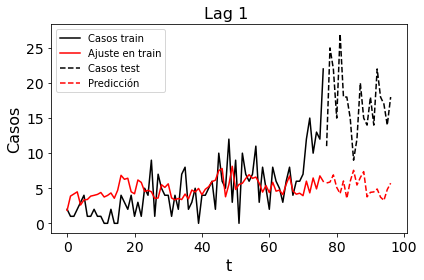

In [43]:
ind_train, ind_test, y_train, y_train_pred, y_test, y_test_pred, r2, mse = poisson_regressor_with(df,1,shuffle=False)

plt.plot(ind_train,y_train, c="k", label="Casos train")
plt.plot(ind_train,y_train_pred, c="r", label = "Ajuste en train")

plt.plot(ind_test,y_test, c="k", linestyle="--", label = "Casos test")
plt.plot(ind_test,y_test_pred, c="r", linestyle="--", label = "Predicción")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('t', fontsize = 16)    
plt.ylabel('Casos', fontsize = 16)  
plt.title("Lag 1 ", fontsize = 16)
plt.legend()
plt.tight_layout()
# plt.savefig("outputs/poissonReg_lag1.pdf", dpi = 200)
plt.show()

In [30]:
def varying_slag(li, ls, step = 1, shuffle = True):
    performance = {"slag":[], 
                "r2-ajustado":[], 
                "test MSE": []}
    for i in range(li,ls,step):
        performance["slag"].append(i)
        ind_train, ind_test, y_train, y_train_pred, y_test, y_test_pred, r2, mse = poisson_regressor_with(df, 
                                    slag = i, 
                                    shuffle = shuffle)
        performance["r2-ajustado"].append(r2)
        performance["test MSE"].append(mse)
    performance = pd.DataFrame(performance)
    performance["sem"] = performance["slag"] / 7
    return performance

    
def plot_performance(performance, col, ylabel, figsize = (6,4), log_scale = False):
    fig, ax = plt.subplots(figsize=figsize)
    plt.grid()
    plt.plot(performance["slag"],performance[col], 
             linewidth = 2.5, 
            #  c = "#F37B01",
             marker = 'o',
             markersize = 8)
    # ax.set_xticks(list(performance["slag"]))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    if log_scale == True:
        plt.yscale("log")    
    plt.xlabel('Lag', fontsize = 16)    
    plt.ylabel(ylabel, fontsize = 16)  
    plt.tight_layout()    

In [29]:
# performance = varying_slag(li=1,ls=20,step=1,shuffle=True)
# plot_performance(performance, 
#                  col = "r2-ajustado",
#                  ylabel = r'$R^2$ ajustado')
# # plt.savefig("outputs/linerreg_r2_ajusted.pdf", dpi = 200)
# plt.show()


score during test: -0.047196474061044213 || MSE: 55.17283786159114
score during test: -0.1708561315720598 || MSE: 59.63662031473276
score during test: -0.24428134655384248 || MSE: 34.0577412878886
score during test: -0.40159954384958163 || MSE: 32.90746317156106
score during test: -0.5511726435953654 || MSE: 69.2558674631361
score during test: -1.6383163221779933 || MSE: 135.98975498022332
score during test: -2.4702073973556082 || MSE: 150.62959403925214
score during test: -0.9969039522269523 || MSE: 57.42924848782176
score during test: -0.6465255794300406 || MSE: 53.27407124699948
score during test: -1.2870216675444532 || MSE: 86.73507700590922
score during test: -0.2689041036750499 || MSE: 67.49981219525948
score during test: -0.5246139763097042 || MSE: 92.58949823329107


/Users/juanolmos/opt/anaconda3/envs/dl/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


score during test: -2.4192530312223144 || MSE: 201.58625712593383
score during test: -2.752708674007869 || MSE: 641.1553964051005
score during test: -0.5125696395117485 || MSE: 56.411189876478076
score during test: -3.0432190083133754 || MSE: 364.91446875860873
score during test: -4.061397180574504 || MSE: 896.5804146992219
score during test: -2.5505892801131775 || MSE: 135.2285463577812
score during test: -1.536225754992333 || MSE: 65.82499730814773
score during test: -3.629091632989292 || MSE: 201.00952763835602
score during test: -3.7842184949668347 || MSE: 266.9674345534981
score during test: -4.358465414843209 || MSE: 1030.898282828704
score during test: -3.0800207169502505 || MSE: 322.976397579561
score during test: -1.5388972271827268 || MSE: 162.10342132157535
score during test: -2.9019817089747235 || MSE: 168.6861995276574
score during test: -8.207239083333981 || MSE: 1034.7455723827015
score during test: -1.7824896561253252 || MSE: 390.72761869155056
score during test: -0.625

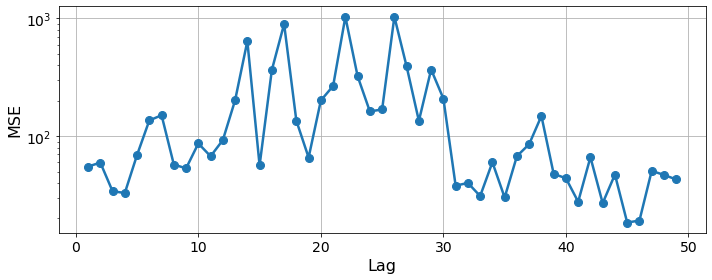

In [39]:
performance = varying_slag(li=1,ls=50,step=1,shuffle=True)
plot_performance(performance, 
                 col = "test MSE",
                 ylabel = "MSE",
                 figsize = (10,4), 
                 log_scale = True)
plt.savefig("outputs/poissonreg_mse.pdf", dpi = 200)
plt.show()

In [27]:
performance

,slag,r2-ajustado,test MSE,sem
0,1,0.127939,55.172838,0.142857
1,2,0.137989,59.636620,0.285714
2,3,0.159290,34.057741,0.428571
3,4,0.195709,32.907463,0.571429
4,5,0.315632,69.255867,0.714286
5,6,0.436055,135.989755,0.857143
6,7,0.486730,150.629594,1.000000
7,8,0.456151,57.429248,1.142857
8,9,0.566129,53.274071,1.285714
9,10,0.676027,86.735077,1.428571


# References
* https://timeseriesreasoning.com/contents/poisson-regression-model/